# Covariance Maximum Likelihood and Matrix Free Optimization
---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pynoisy
import xarray as xr
from tqdm.notebook import tqdm as tqdm
import scipy as sci
from ipywidgets import interact, interactive
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams['mathtext.fontset'] = 'stix'

## Krylov Subspace

References

---
[1] https://en.wikipedia.org/wiki/Matrix-free_methods

[2] https://en.wikipedia.org/wiki/Krylov_subspace

[3] https://en.wikipedia.org/wiki/Arnoldi_iteration

[4] https://arxiv.org/pdf/1811.09025.pdf


In [2]:
def get_krylov_matrix(solver, measurements, degree):
    k_matrix = []
    b = measurements.copy()
    for i in range(degree):
        b = solver.run_symmetric(source=b.copy(), verbose=False)
        k_matrix.append(np.array(b).ravel())
    return np.array(k_matrix)

def compute_krylov_error(angle, measurements, solver, degree=8):
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=angle))
    k_matrix = get_krylov_matrix(solver, measurements, degree)
    error = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=None)[1]
    return error
    
def add_noise(measurements, noise_precent):
    noise = np.sqrt(np.abs(measurements)) * np.random.randn(*measurements.shape) * noise_precent
    noisy_meas = measurements.copy() + noise
    return noisy_meas

### Visualization

In [41]:
solver = pynoisy.forward.NoisySolver(
    pynoisy.advection.disk(), pynoisy.diffusion.ring(opening_angle=np.pi/3.0)
)
measurements = solver.run_asymmetric(verbose=False)

degree = 8

solver.reseed()
solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=0))
k_matrix = get_krylov_matrix(solver, measurements, degree)
k_movies = xr.DataArray(
    data=k_matrix.reshape(degree, *measurements.shape),
    coords=measurements.expand_dims(k=np.arange(degree)).coords,
)

In [42]:
coef = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=None)
print('residual: {}'.format(coef[1]))

residual: [1798875.81630354]


<IPython.core.display.Javascript object>


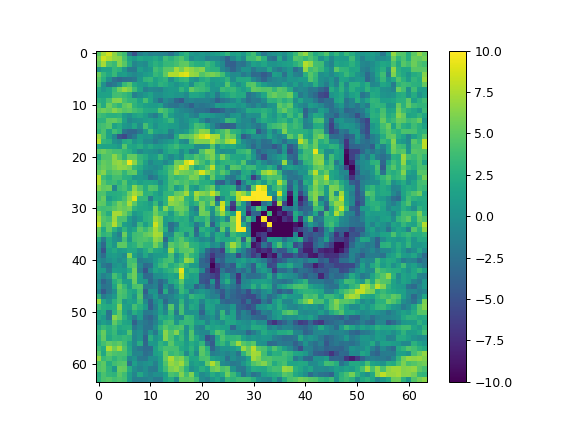

In [45]:
%matplotlib notebook
measurements.noisy_methods.get_animation(vmin=-10, vmax=10)

<IPython.core.display.Javascript object>


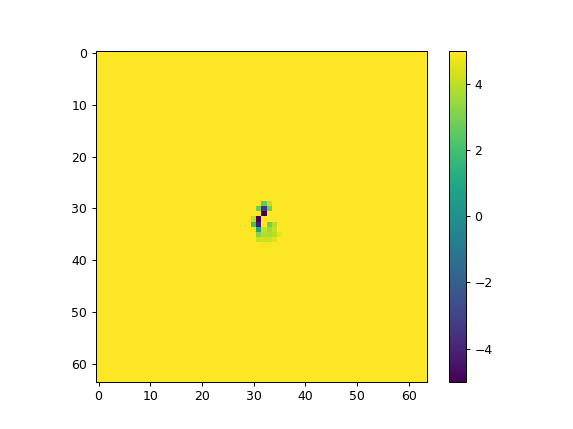

In [47]:
%matplotlib notebook
k_movies[0].noisy_methods.get_animation(vmin=-5, vmax=5)

In [48]:
rec_deg = 8
reconstruction = xr.DataArray(
    data=np.dot(coef[0][:rec_deg].T, k_matrix[:rec_deg]).reshape(*measurements.shape),
    coords=measurements.coords
)

<IPython.core.display.Javascript object>


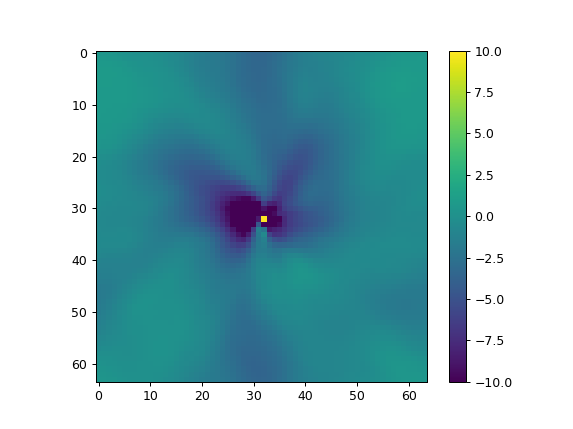

In [51]:
%matplotlib notebook
reconstruction.noisy_methods.get_animation(vmin=-10, vmax=10)

<IPython.core.display.Javascript object>


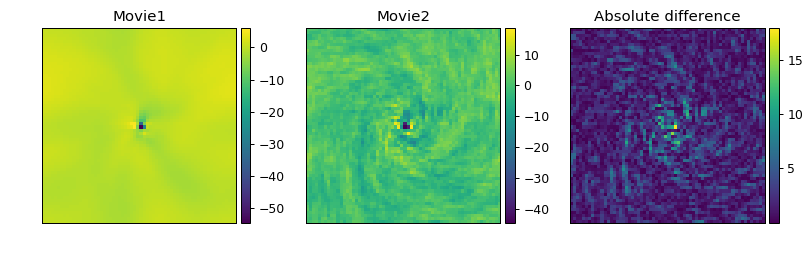

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [52]:
pynoisy.utils.compare_movie_frames(reconstruction, measurements)

### Loss Analsysis

#### Without model error

In [ ]:
n_jobs = 12
angle_range = np.linspace(0, 1.5*np.pi, 50)

advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)

losses = []
for i in tqdm(range(1), desc='Random measurement loop'):
    solver.reseed()
    measurements = solver.run_symmetric(verbose=False)
    loss = Parallel(n_jobs=n_jobs)(
        delayed(compute_krylov_error)(angle, measurements, solver) for angle in 
        tqdm(angle_range, desc='Angle range loop', leave=False)
    )
    losses.append(loss)
losses = np.array(losses).T

<IPython.core.display.Javascript object>


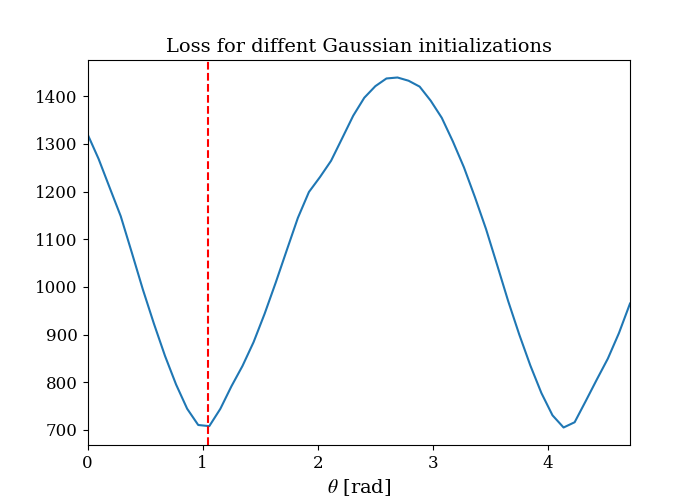

In [16]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Loss for diffent Gaussian initializations', fontsize=14)
ax.plot(angle_range, np.array(losses).squeeze().T)
ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--');
ax.set_xlabel(r'$\theta$ [rad]', fontsize=14)
ax.set_xlim([0.0, 1.5*np.pi]);

#### With model error

In [4]:
n_jobs = 50
angle_range = np.linspace(0, 1.5*np.pi, 50)

advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)

losses = []
for i in tqdm(range(1), desc='Random measurement loop'):
    solver.reseed()
    measurements = solver.run_asymmetric(verbose=False)
    loss = Parallel(n_jobs=n_jobs)(
        delayed(compute_krylov_error)(angle, measurements, solver) for angle in 
        tqdm(angle_range, desc='Angle range loop', leave=False)
    )
    losses.append(loss)
losses = np.array(losses).T

<IPython.core.display.Javascript object>


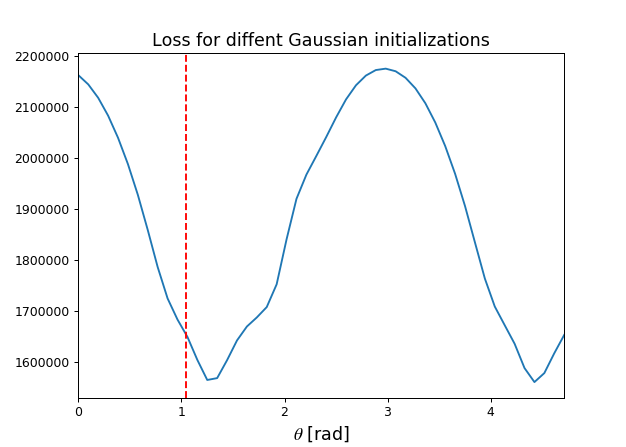

In [5]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Loss for diffent Gaussian initializations', fontsize=14)
ax.plot(angle_range, np.array(losses).squeeze().T)
ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--');
ax.set_xlabel(r'$\theta$ [rad]', fontsize=14)
ax.set_xlim([0.0, 1.5*np.pi]);

#### With addative noise

In [ ]:
n_jobs = 50
angle_range = np.linspace(0, 1.5*np.pi, 50)

advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)

losses = []

num_noise_draws = 20

# Without model error
measurements = solver.run_symmetric(verbose=False)

# With model error 
# measurements = solver.run_asymmetric(verbose=False)

noise_precent = np.linspace(0.0, 1.0, 11)
for sigma in tqdm(noise_precent, desc='Noise precent loop'):
    loss = []
    for i in tqdm(range(num_noise_draws), desc='Noise draws loop', leave=False):
        noisy_meas = add_noise(measurements, sigma)
        loss.append(Parallel(n_jobs=n_jobs)(
            delayed(compute_krylov_error)(angle, noisy_meas, solver) for angle in 
            tqdm(angle_range, desc='Angle range loop', leave=False)))
    
    # Collect statistics
    loss_stats = xr.Dataset(
        data_vars={'mean': ('opening_angle', np.array(loss).mean(axis=0).squeeze()), 
                   'std': ('opening_angle', np.array(loss).std(axis=0).squeeze())},
        coords={'opening_angle': angle_range})
    losses.append(loss_stats)

losses = xr.merge(losses)
losses.to_netcdf('krylov_losses_with_additive_noise.nc')

In [84]:
"""
Plot losses with and without model error 
"""
def update(index):
    loss = losses[index]
    sigma = noise_precent[index]
    plt.cla()
    ax.plot(angle_range, loss['mean'].squeeze())
    ax.set_xlim([angle_range[0], angle_range[-1]]);
    ax.fill_between(angle_range, loss['mean'].squeeze() +  loss['std'].squeeze(), loss['mean'].squeeze() - loss['std'].squeeze(), facecolor='blue', alpha=0.5)
    ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--')
    ax.set_title(r'Loss $=  \|\| \left( F(\theta_t) + \sqrt{F(\theta_t)} \sigma \epsilon \right) - K_\theta \hat c_\theta  \|\|^2$   for $\sigma={:1.2}$'.format(sigma), fontsize=14)

<IPython.core.display.Javascript object>


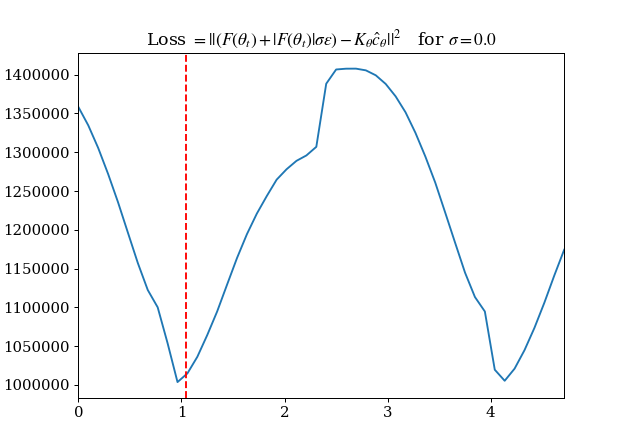

interactive(children=(IntSlider(value=5, description='index', max=10), Output()), _dom_classes=('widget-intera…

In [87]:
losses = np.load('losses.npy', allow_pickle=True)    
noise_precent = np.linspace(0.0, 1.0, 11)

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
interact(update, index=(0, len(losses)-1));

<IPython.core.display.Javascript object>


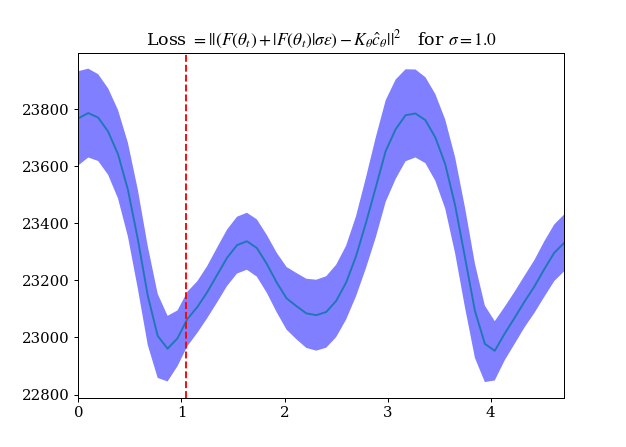

interactive(children=(IntSlider(value=2, description='index', max=4), Output()), _dom_classes=('widget-interac…

In [92]:
losses = np.load('losses_without_model_error.npy', allow_pickle=True)    
noise_precent = np.linspace(0.0, 1.0, 5)

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
interact(update, index=(0, len(losses)-1));

## Maximum Likelihood

The forward model equation is described by 
$$ {\bf y} = {\bf A} {\bf n}$$
Where ${\bf n}$ is white Gaussian noise with 

$${\bf \mu}_n = {\bf 0}, \quad {\bf \Sigma}_n = {\bf I}$$

The measurements vector ${\bf y}$ is therfor also multivariate Gaussian with 

$${\bf \mu}_y = {\bf 0}, \quad {\bf \Sigma}_y = {\bf A}{\bf A}^\top$$

The Maximum likelihood estimator[1] for ${\bf A}$ solves a covariance estimation problem (due to the multiplicative noise instead of an addative term) which gives rise to the following optimization

$$\max\limits_{{\bf \Theta}} \left[ \log \det {\bf A}_{{\bf \Theta}}{\bf A}_{\bf \Theta}^\top - {\rm tr}\left( {\bf S} {\bf A}_{\bf \Theta}{\bf A}_{\bf \Theta}^\top\right) - \alpha \| {\bf A}_{\bf \Theta}{\bf A}_{\bf \Theta}^\top \|_1\right]$$

Here ${\bf S} = {\bf y}{\bf y}^\top$ is the Scatter matrix or the empirical covariance (up to the normalization by the number of samples). Further more $\alpha>0$ is give rise to  **Graphical Lasso**[2,3,4]

---
[1] https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices

[2] https://scikit-learn.org/stable/modules/generated/sklearn.covariance.graphical_lasso.html

[3] https://arxiv.org/pdf/1802.04911.pdf#cite.Friedman08

[4] http://statweb.stanford.edu/~tibs/ftp/graph.pdf

[5] https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf

<IPython.core.display.Javascript object>


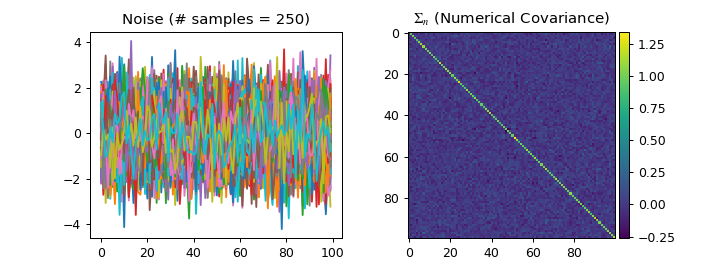

interactive(children=(IntSlider(value=250, description='num_samples', max=500, min=1), Output()), _dom_classes…

In [5]:
def update(num_samples):
    n = np.random.randn(signal_length, num_samples)
    if num_samples == 1:
        sigma = np.matmul((b-b.mean())[None].T, (b-b.mean())[None])
    else:
        sigma = np.cov(n)
    plt.sca(ax[0])
    plt.cla()
    ax[0].plot(n)
    ax[0].set_title('Noise (# samples = {})'.format(num_samples), fontsize=12);
    ax[1].imshow(sigma)
    cbar.mappable.set_clim([sigma.min(), sigma.max()])

signal_length = 100
max_num_samples = 500

%matplotlib notebook
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].set_title('Noise', fontsize=12);
ax[1].set_title('$\Sigma_n$ (Numerical Covariance)', fontsize=12);
im = ax[1].imshow(np.random.randn(signal_length, signal_length))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax)
interact(update, num_samples=(1, max_num_samples))
plt.show()

In [6]:
def get_a(seed, x):
    a = seed * np.repeat([np.sin(x), np.exp(np.cos(x)), np.cos(x), 
                          np.exp(-np.sin(x)**2), np.cos(x)**2*np.sin(x)], 
                         signal_length/5)[None]
    return np.dot(a, a.T) + np.eye(signal_length)

signal_length = 1000
num_samples = 1

nt = np.random.randn(signal_length, num_samples)
seed = 0.1 * np.random.randn(signal_length, signal_length) 
A = lambda x: get_a(seed, x)
At =  A(1.04)
y = np.matmul(At, nt)

if num_samples == 1:
    S = np.matmul((y-y.mean()), (y-y.mean()).T)
else:
    S = np.cov(y)

<IPython.core.display.Javascript object>


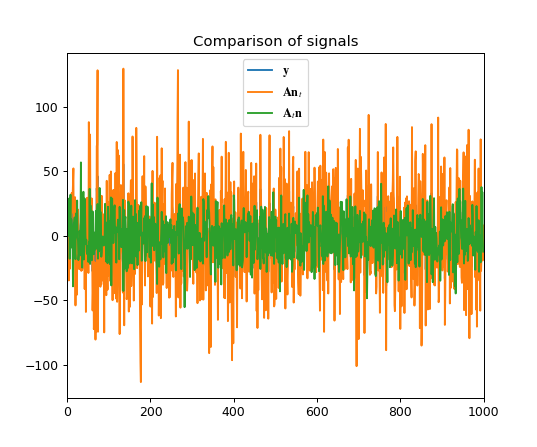

Text(0.5, 1.0, 'Comparison of signals')

In [7]:
plt.figure(figsize=(6,5))
plt.plot(y, label=r'${\bf y}$')
plt.plot(np.matmul(A(0.0), nt), label=r'${\bf A} {\bf n}_t$')
plt.plot(np.matmul(A(1.0), np.random.randn(signal_length)), label=r'${\bf A}_t {\bf n}$')
plt.xlim([0, signal_length])
plt.legend()
plt.title('Comparison of signals')

<IPython.core.display.Javascript object>


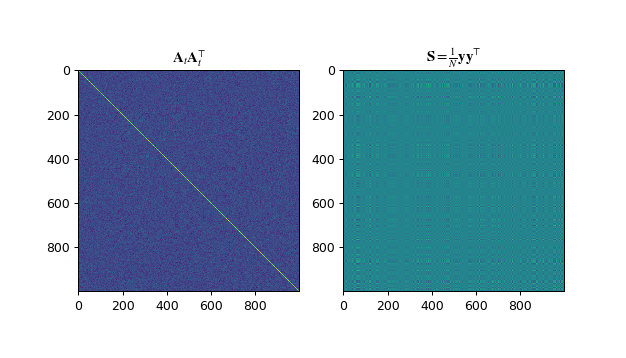

In [9]:
AATt = np.matmul(At, At.T)

%matplotlib notebook
fig, ax = plt.subplots(1,2,figsize=(7,4))
ax[0].imshow(AATt)
ax[0].set_title(r'${\bf A}_t {\bf A}_t^\top$')
ax[1].imshow(S)
ax[1].set_title(r'${\bf S} = \frac{1}{N}{\bf y} {\bf y}^\top$');